Required packets

In [1]:
from pandas import read_csv, Timedelta
import torch
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

## Peek Detection

Load the transform and retrive the right threshold based on the scale, need to understand how to deal with trend probably must be sum

In [2]:
series = read_csv('coefficents.csv', header = 0, index_col = 0, parse_dates= True)

# Initialize lists to store coefficients and heights
wav_coef = []
height = []
time_index = series.index
time_diff = time_index.to_series().diff().min()
dim = series.shape[0]

# To decide the threshold based on the sampling frequency
daily_threshold = Timedelta(days=1)
weekly_threshold = Timedelta(weeks=1)
monthly_threshold = Timedelta(days=28)

print(time_diff)

if time_diff < daily_threshold:
  time_diff = 0
  final_result = torch.zeros(dim, 4)
  # Iterate over each column in the DataFrame
  for column in series.columns:
      # Get the values of the current column
      coef = series[column].values

      # Append the coefficients to the list
      wav_coef.append(coef)

      # Determine the height based on the column name or any other criteria
      if 'daily' in column.lower():
          height.append(1)
      elif 'weekly' in column.lower():
          height.append(2)
      elif 'monthly' in column.lower():
          height.append(4)
      elif 'yearly' in column.lower():
          height.append(15)
      else:
          # Handle other cases as needed
          raise ValueError("Unsupported Frequency")
elif time_diff == daily_threshold:
  time_diff = 1
  final_result = torch.zeros(dim, 3)
  # Iterate over each column in the DataFrame
  for column in series.columns:
      # Get the values of the current column
      coef = series[column].values

      # Append the coefficients to the list
      wav_coef.append(coef)

      # Determine the height based on the column name or any other criteria
      if 'weekly' in column.lower():
          height.append(0.5)
      elif 'monthly' in column.lower():
          height.append(1)
      elif 'yearly' in column.lower():
          height.append(2)
      else:
          # Handle other cases as needed
          raise ValueError("Unsupported Frequency")
elif time_diff == weekly_threshold:
  time_diff = 2
  final_result = torch.zeros(dim, 2)
  # Iterate over each column in the DataFrame
  for column in series.columns:
      # Get the values of the current column
      coef = series[column].values

      # Append the coefficients to the list
      wav_coef.append(coef)
      if 'monthly' in column.lower():
          height.append(0.5)
      elif 'yearly' in column.lower():
          height.append(1)
      else:
          # Handle other cases as needed
          raise ValueError("Unsupported Frequency")
elif time_diff == monthly_threshold:
  time_diff = 3
  final_result = torch.zeros(dim, 1)
  # Iterate over each column in the DataFrame
  for column in series.columns:
    # Get the values of the current column
    coef = series[column].values

    # Append the coefficients to the list
    wav_coef.append(coef)

    if 'yearly' in column.lower():
        height.append(1)
    else:
        # Handle other cases as needed
        raise ValueError("Unsupported Frequency")

0 days 01:00:00


Find the index for each scale of those part with a match higher then the threshold

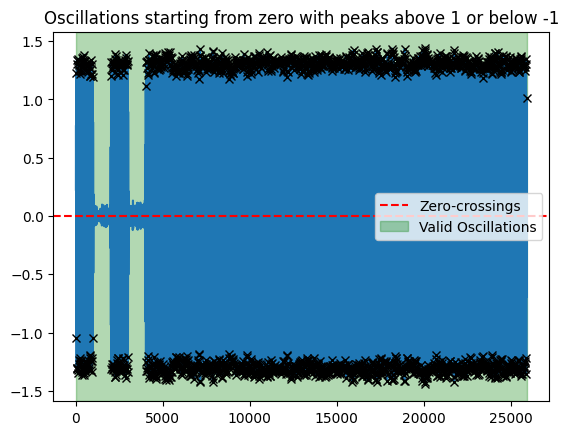

Indices of all oscillations: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,

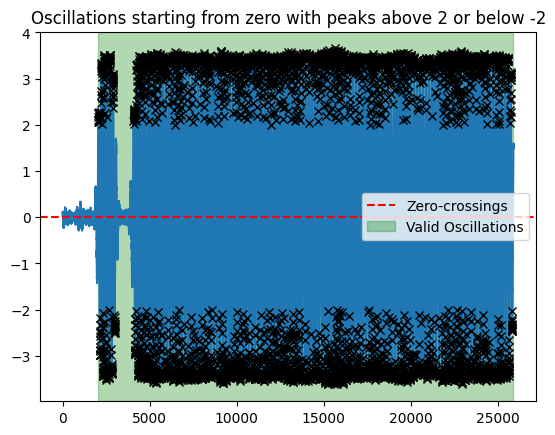

Indices of all oscillations: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173

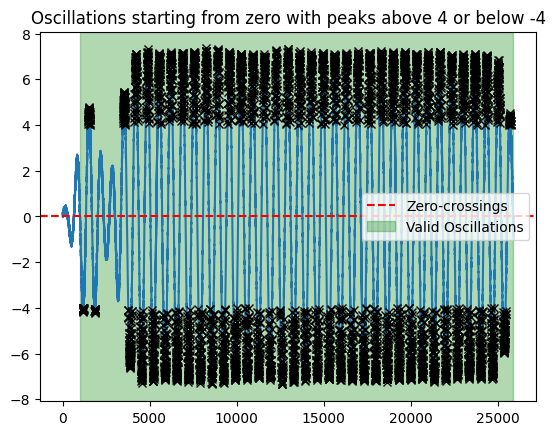

Indices of all oscillations: [998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 

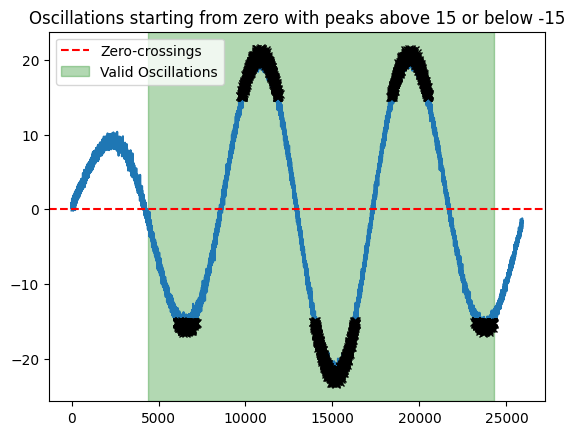

Indices of all oscillations: [4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 4453, 4454, 4455, 4456, 4457, 4458, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4472, 4473, 4474, 4475, 4476, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517, 4518, 4519, 4520, 4521, 4522, 4523, 4524, 4525, 4526, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534, 4535, 4536

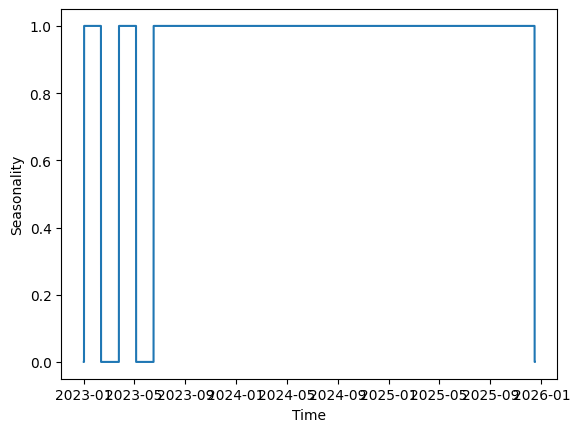

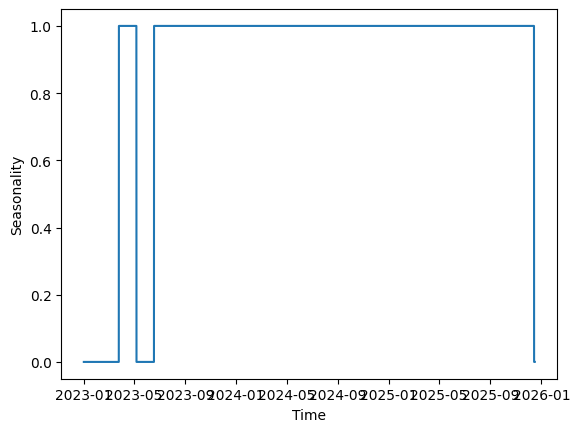

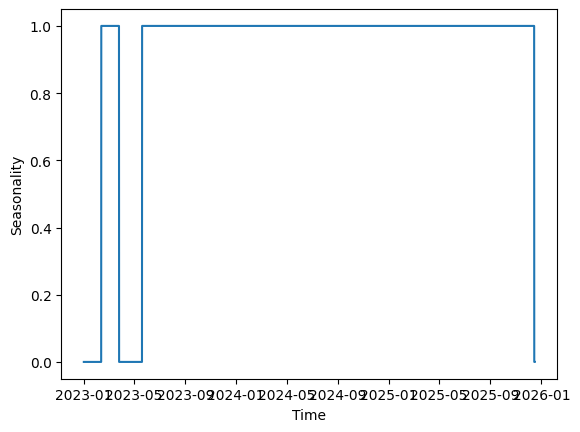

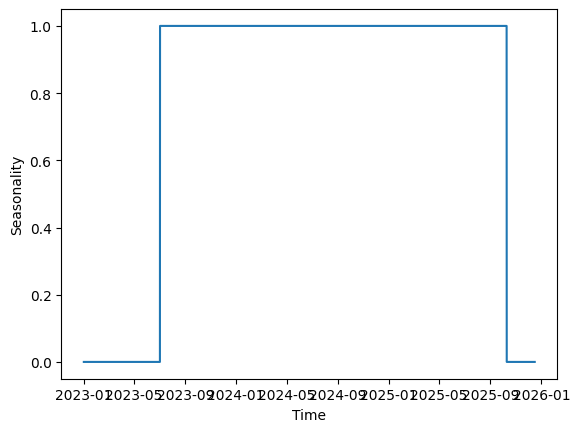

In [3]:
iter = 0
for height, coef in zip(height, wav_coef):
  iter = iter + 1
  # Assuming coef is your ndarray
  peaks_above, _ = find_peaks(coef, height)
  peaks_below, _ = find_peaks(-coef, height)
  # Combine the peaks from both conditions
  all_peaks = np.concatenate([peaks_above, peaks_below])
  # Sort the indices for plotting purposes
  all_peaks = np.sort(all_peaks)

  # Find zero-crossings by detecting sign changes
  coefsign = np.sign(coef)
  signchange = ((np.roll(coefsign, 1) - coefsign) != 0).astype(int)
  zero_crossings = np.where(signchange == 1)[0]

  # Initialize an array to store indices of all oscillations
  all_oscillations = []

  if all_peaks.size == 0:
    print(f'All points under {height}')
    continue

  if all_peaks[0] < zero_crossings[0]:
    i = zero_crossings[0]
    all_oscillations.extend(range(0, i))

  # Iterate through zero-crossings to identify entire oscillations
  for i in range(len(zero_crossings) - 1):
      start_index = zero_crossings[i]
      end_index = zero_crossings[i + 1]

      # Check if there are peaks above the threshold within the interval
      if np.max(coef[start_index:end_index]) > height or np.min(coef[start_index:end_index]) < -height:
          all_oscillations.extend(range(start_index, end_index + 1))



  # Check if the last peak is above the threshold
  if all_peaks[-1] > zero_crossings[-1]:
      start_index = zero_crossings[-1]
      end_index = all_peaks[-1]


      # Extend the oscillation to the right if values are increasing

      while end_index < len(coef) - 1 and coef[end_index] > coef[end_index + 1]:
          end_index += 1

      all_oscillations.extend(range(start_index, end_index + 1))

  # Select unique indexes
  all_oscillations = np.unique(all_oscillations).tolist()

  # Plotting
  plt.plot(coef)
  plt.plot(all_peaks, coef[all_peaks], "xk")
  plt.axhline(y=0, color='r', linestyle='--', label='Zero-crossings')
  plt.axvspan(all_oscillations[0], all_oscillations[-1], color='green', alpha=0.3, label='Valid Oscillations')
  plt.title(f'Oscillations starting from zero with peaks above {height} or below {-height}')
  plt.legend()
  plt.show()

  # Print the array of all oscillations indices
  print("Indices of all oscillations:", all_oscillations)

  # Check for consecutive index
  for i in range(len(all_oscillations)-1):
    if all_oscillations[i]+1 != all_oscillations[i+1]:
      count = all_oscillations[i+1]-all_oscillations[i]
      if time_diff == 0:
        if iter == 1 and count <= 24:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif iter == 2 and count <= 24*7:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif iter == 3 and count <= 24*28:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif iter == 4 and count <= 24*360:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
      elif time_diff == 1:
        if iter == 1 and count <= 7:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif iter == 2 and count <= 28:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif iter == 3 and count <= 360:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
      elif time_diff == 2:
        if iter == 1 and count <= 4:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif iter == 2 and count <= 4*12:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
      else:
        if count <= 12:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))

  all_oscillations = np.unique(all_oscillations)
  non_consecutive_indices = []

  # Check for consecutive index
  i = 0
  while i < len(all_oscillations) - 1:
      start_index = all_oscillations[i]
      end_index = all_oscillations[i]

      # Find the end of the consecutive sequence
      while i < len(all_oscillations) - 1 and all_oscillations[i] + 1 == all_oscillations[i+1]:
          end_index = all_oscillations[i+1]
          i += 1

      # Check if the consecutive sequence is shorter than the count
      count = end_index - start_index + 1
      if time_diff == 0 and iter == 1 and count <= 24:
          non_consecutive_indices.extend(range(start_index, end_index + 1))
      elif time_diff == 1 and iter == 1 and count <= 7:
          non_consecutive_indices.extend(range(start_index, end_index + 1))
      elif time_diff == 1 and iter == 2 and count <= 28:
          non_consecutive_indices.extend(range(start_index, end_index + 1))
      elif time_diff == 1 and iter == 3 and count <= 360:
          non_consecutive_indices.extend(range(start_index, end_index + 1))
      elif time_diff == 2 and iter == 1 and count <= 4:
          non_consecutive_indices.extend(range(start_index, end_index + 1))
      elif time_diff == 2 and iter == 2 and count <= 4*12:
          non_consecutive_indices.extend(range(start_index, end_index + 1))
      elif count <= 12:
          non_consecutive_indices.extend(range(start_index, end_index + 1))

      i += 1

  # Remove consecutive indices shorter than the count threshold from all_oscillations
  all_oscillations = np.array([index for index in all_oscillations if index not in non_consecutive_indices])

  i=0

  for i in range(len(all_oscillations)-1):
    if all_oscillations[i]+1 != all_oscillations[i+1]:
      print(f"No consecutive index {all_oscillations[i]}-{all_oscillations[i+1]}")

  print(all_oscillations)

  # Itera su ogni indice in all_oscillations
  for idx in all_oscillations:
    # Aggiorna il valore nella riga corrispondente del tensore final_result
    final_result[idx, iter-1] = 1


  print(final_result.shape)
  torch.save(final_result, 'result.pt')
# Plot
for i in range(final_result.shape[1]):
  plt.plot(time_index, final_result[:,i])
  plt.xlabel('Time')
  plt.ylabel('Seasonality')
  plt.show()